In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from scipy.ndimage import gaussian_filter1d

import burst_detector as bd

In [2]:
#rec_time = "0900"
#file_path = "20240914_SD1_test_" + rec_time + "_g0/catgt_20240914_SD1_test_" + rec_time + "_g0/20240914_SD1_test_" + rec_time + "_g0_imec0/imec0_ks25"

# parameters
bin_size = 30000

sample_rate = 30000
sigma = 6

In [3]:
## function for calculating firing rate of each neuron(clsuters)
# Input:
# - spike_time_files = spike_times.npy
# - spike_clusters_file = spike_clusters.npy
# - bin_size = in sample numbers (30kHz), binwidth for calculating firing rate
# - cluster = select for which clusters to calculate firing rate

# Output:
# - fr [cluster #, (total length/ bin width)]: binned firing rate for each cluster
# - t_bins [(total length/ bin width),]: vector of binned time stamp
# - clust_num [int]: number of clusters

def firing_rate_calc(spike_times_file, spike_clusters_file, cluster_label_file, bin_size, cluster):
    spike_times = np.load(spike_times_file)
    spike_clusters = np.load(spike_clusters_file)
    clust_label = pd.read_csv(cluster_label_file, sep='\t')

    if cluster == "all":
        clust_tot = len(np.unique(spike_clusters))
        clust_ind = clust_label.index[clust_label["label"] == "good"].tolist()
    else:
        clust_ind = cluster
    t_end = np.max(spike_times)
    t_bins = np.arange(0,t_end,bin_size)
    
    clust_num = len(clust_ind)
    fr = np.zeros((len(clust_ind), len(t_bins)-1))
    for i in range(len(clust_ind)):
        spikes_t_ind = spike_times[np.where(spike_clusters == clust_ind[i])[0]]
        spikes_count, edges = np.histogram(spikes_t_ind, t_bins)

        fr[i,:] = spikes_count

    return fr, t_bins[:-1], clust_num, clust_tot

In [8]:
## function for smoothing firing rate via gaussian filter
# Input:
# - fr
# - sigma: standard deviation of gaussian kernel

# Output:
# - fr_smooth

def firing_rate_smooth(fr, sigma):
    fr_smooth = np.zeros(fr.shape)
    for i in range(len(fr_smooth)):
        fr_smooth[i,:] = gaussian_filter1d(fr[i,:], sigma)

    return fr_smooth

In [ ]:
cluster_ind = np.unique(spike_clusters)

cluster_spike_count = np.zeros(len(cluster_ind))
for i in range(len(cluster_ind)):
    count = len(np.where(spike_clusters == cluster_ind[i])[0])
    cluster_spike_count[i] = count

firing_rate = cluster_spike_count/(np.max(spike_times)/30000)

df = pd.DataFrame({'cluster_id':cluster_ind, 'firing_rate':firing_rate})

In [10]:
def firing_rate_metics(spike_times_file, spike_clusters_file):
    spike_times = np.load(spike_times_file)
    spike_clusters = np.load(spike_clusters_file)

    clust_ind = np.unique(spike_clusters)
    cluster_spike_count = np.zeros(len(clust_ind))

    for i in range(len(clust_ind)):
        count = len(np.where(spike_clusters == clust_ind[i])[0])
        cluster_spike_count[i] = count

    firing_rate = cluster_spike_count/(np.max(spike_times)/30000)

    df = pd.DataFrame({'cluster_id':clust_ind, 'firing_rate':firing_rate})
    
    return df

In [11]:
# MAIN SCRIPT FOR CALCULATING FIRING RATE

# going through all the different recording sessions
t_stamp = ["0900", "1000", "1100", "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100"]
file_dir = "Z:/Wu_sleep/m2/SD1/"
file_date = "20240923"

mean_fr_sessions = []

for s in range(len(t_stamp)):
    file_path = file_date + "_SD1_test_" + t_stamp[s] + "_g0/catgt_" + file_date + "_SD1_test_" + t_stamp[s] + "_g0/" + file_date + "_SD1_test_" + t_stamp[s] + "_g0_imec0/imec0_ks25"
    spike_times_file = file_dir + file_path + "/spike_times.npy"
    spike_clusters_file = file_dir + file_path + "/spike_clusters.npy"
    cluster_label_file = file_dir + file_path + "/cluster_group.tsv"
    

    fr, t_bins, clust_num, clust_tot = firing_rate_calc(spike_times_file, spike_clusters_file, cluster_label_file, bin_size, "all")
    fr_smooth = firing_rate_smooth(fr, sigma)

    # taking average of binned firing rate for each cluster
    fr_smooth_avg = np.average(fr_smooth, axis=1)

    # save total cluster fr data in vector for each session
    mean_fr_sessions.append(fr_smooth_avg)

    # update post-curation metrics file with firing rate for neuron tracking
    fr_df = firing_rate_metics(spike_times_file, spike_clusters_file)
    fr_df.to_csv(os.path.join(file_dir + file_path, r"metrics_curated.csv"))

    

In [18]:
t_stamp = ["0900", "1000", "1100", "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100"]
file_dir = "Z:/Wu_sleep/m1/SD1/"
file_date = "20240914"

clust_num_all = np.zeros(13)
clust_tot_all = np.zeros(13)
for s in range(len(t_stamp)):
    file_path = file_date + "_SD1_test_" + t_stamp[s] + "_g0/catgt_" + file_date + "_SD1_test_" + t_stamp[s] + "_g0/" + file_date + "_SD1_test_" + t_stamp[s] + "_g0_imec0/imec0_ks25"
    spike_times_file = file_dir + file_path + "/spike_times.npy"
    spike_clusters_file = file_dir + file_path + "/spike_clusters.npy"
    cluster_label_file = file_dir + file_path + "/cluster_group.tsv"
    

    fr, t_bins, clust_num, clust_tot= firing_rate_calc(spike_times_file, spike_clusters_file, cluster_label_file, bin_size, "all")
    clust_num_all[s] = clust_num
    clust_tot_all[s] = clust_tot


In [3]:
spike_times = np.load(r"Z:\Wu_sleep\m1\SD1\20240914_SD1_test_0900_g0\catgt_20240914_SD1_test_0900_g0\20240914_SD1_test_0900_g0_imec0\imec0_ks25\spike_times.npy")
spike_clusters =np.load(r"Z:\Wu_sleep\m1\SD1\20240914_SD1_test_0900_g0\catgt_20240914_SD1_test_0900_g0\20240914_SD1_test_0900_g0_imec0\imec0_ks25\spike_clusters.npy")
cluster_label = r"Z:\Wu_sleep\m1\SD1\20240914_SD1_test_0900_g0\catgt_20240914_SD1_test_0900_g0\20240914_SD1_test_0900_g0_imec0\imec0_ks25\cluster_group.tsv"

clust_ind = np.unique(spike_clusters)

clust_test = (spike_times[spike_clusters == 127]/30000).astype(np.float)
#clust_test.astype(np.float)


C:\Users\alexc\AppData\Local\Temp\ipykernel_39688\2501792696.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clust_test = (spike_times[spike_clusters == 127]/30000).astype(np.float)


In [4]:
bursts, q, a = bd.find_bursts(clust_test)

In [6]:
bursts

,level,start,end
0,1,60.674567,61.288200
1,1,86.766367,89.722867
2,1,94.793567,95.709567
3,1,100.878867,101.812900
4,1,181.918233,181.960767
5,2,181.918233,181.960767
6,3,181.918233,181.960767
7,1,194.632567,257.020133
8,1,280.314467,281.333867
9,1,332.777467,354.141967


In [6]:
q

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

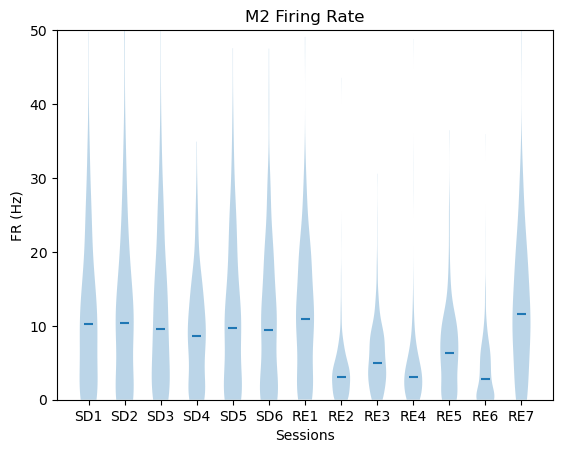

In [69]:
plt.violinplot(mean_fr_sessions,showmedians=True, showextrema=False)

plt.ylim([0,50])
plt.title("M2 Firing Rate")
plt.xticks(np.arange(13)+1, ["SD1", "SD2", "SD3", "SD4", "SD5", "SD6", "RE1", "RE2", "RE3", "RE4", "RE5", "RE6", "RE7"])
plt.xlabel("Sessions")
plt.ylabel("FR (Hz)")
plt.show()

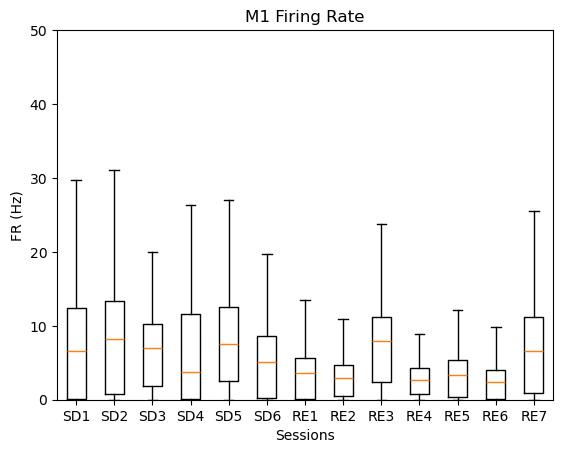

In [74]:
plt.boxplot(mean_fr_sessions, sym="")

plt.ylim([0,50])
plt.title("M1 Firing Rate")
plt.xticks(np.arange(13)+1, ["SD1", "SD2", "SD3", "SD4", "SD5", "SD6", "RE1", "RE2", "RE3", "RE4", "RE5", "RE6", "RE7"])
plt.xlabel("Sessions")
plt.ylabel("FR (Hz)")
plt.show()